Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [114]:
%matplotlib inline

In [115]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [83]:
def logistic_regression_graph(train_subset, l2_gamma = 0.):
    graph = tf.Graph()
    with graph.as_default():
        # Input data.
        # Load the training, validation and test data into constants that are
        # attached to the graph.
        tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
        tf_train_labels = tf.constant(train_labels[:train_subset])
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        # These are the parameters that we are going to be training. The weight
        # matrix will be initialized using random values following a (truncated)
        # normal distribution. The biases get initialized to zero.
        weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
        biases = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        # We multiply the inputs with the weight matrix, and add biases. We compute
        # the softmax and cross-entropy (it's one operation in TensorFlow, because
        # it's very common, and it can be optimized). We take the average of this
        # cross-entropy across all training examples: that's our loss.
        logits = tf.matmul(tf_train_dataset, weights) + biases
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
        loss += l2_gamma * (tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))

        # Optimizer.
        # We are going to find the minimum of this loss using gradient descent.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        # These are not part of training, but merely here so that we can report
        # accuracy figures as we train.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
        test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    return (graph, optimizer, loss, train_prediction, valid_prediction, test_prediction, weights, biases)

Let's run this computation and iterate:

In [169]:
num_steps = 301

def logistic_regression(train_subset = 1000, l2_gamma = 0.):
    hist = []
    def accuracy(predictions, labels):
        return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

    (graph, optimizer, loss, train_prediction, valid_prediction, test_prediction, weights, biases) = \
        logistic_regression_graph(train_subset, l2_gamma)
        
    with tf.Session(graph=graph) as session:
        # This is a one-time operation which ensures the parameters get initialized as
        # we described in the graph: random weights for the matrix, zeros for the
        # biases. 
        tf.global_variables_initializer().run()
        for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
            _, l, predictions = session.run([optimizer, loss, train_prediction])
            train_acc = accuracy(predictions, train_labels[:train_subset, :])
            val_acc = accuracy(valid_prediction.eval(), valid_labels)
            test_acc = accuracy(test_prediction.eval(), test_labels)
            hist.append([train_acc, val_acc, test_acc, l])

        w = session.run(weights)
        print('Weights mean=%.4f, std=%.3f' % (np.mean(w), np.std(w)))
        b = session.run(biases)
        print('Biases mean =%.4f, std=%.3f' % (np.mean(b), np.std(b)))
        hist = np.array(hist)
        plt.figure(figsize=(14,3))
        plt.subplot(121)
        for i, l in enumerate(['train', 'val', 'test']):
            plt.plot(hist[:,i], label=l)        
        plt.legend()            
        plt.subplot(122)                               
        plt.plot(hist[:,3], label='Loss')                                       
        plt.legend()

Weights mean=-0.0024, std=0.838
Biases mean =0.0000, std=0.532


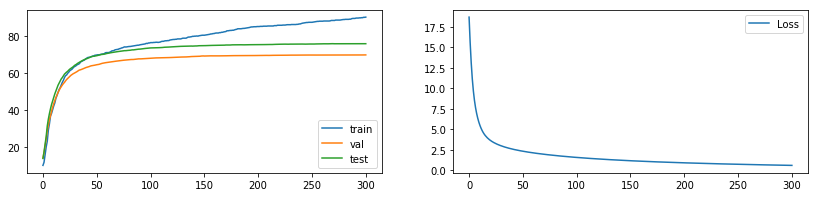

In [170]:
logistic_regression()

Weights mean=0.0000, std=0.024
Biases mean =0.0000, std=0.058


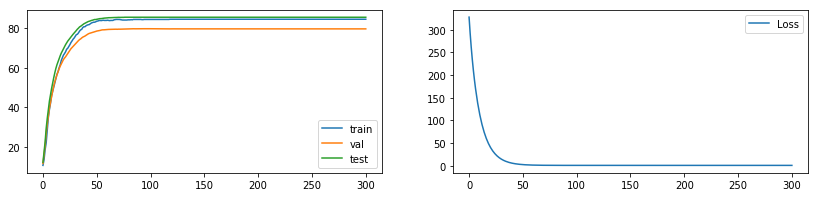

In [171]:
logistic_regression(l2_gamma=0.1)

Weights mean=-0.0000, std=0.033
Biases mean =-0.0000, std=0.099


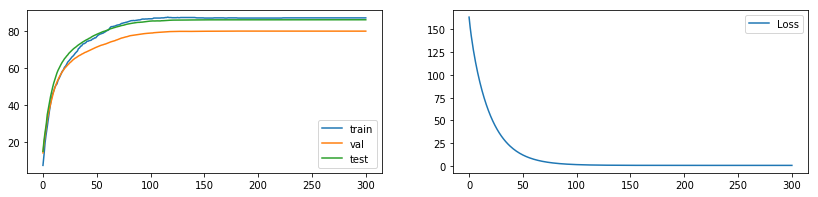

In [172]:
logistic_regression(l2_gamma=0.05)

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [109]:
def one_layer_graph():
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        features = tf.placeholder(tf.float32, shape=(None, image_size * image_size))
        labels =   tf.placeholder(tf.float32, shape=(None, num_labels))

        # Variables.
        weights = [
            tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
        ]
        biases = [
            tf.Variable(tf.zeros([num_labels]))
        ]

        # Training computation.
        logits = tf.matmul(features, weights[0]) + biases[0]
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) * 100
    return graph, optimizer, loss, accuracy, features, labels

In [108]:
def two_layers_graph():
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        features = tf.placeholder(tf.float32, shape=(None, image_size * image_size))
        labels =   tf.placeholder(tf.float32, shape=(None, num_labels))

        # Variables.
        weights = [
            tf.Variable(tf.truncated_normal([image_size * image_size, 1024])),
            tf.Variable(tf.truncated_normal([1024, num_labels]))
        ]
        biases = [
            tf.Variable(tf.zeros([1024])),
            tf.Variable(tf.zeros([num_labels]))        
        ]

        # Training computation.
        h = tf.matmul(features, weights[0]) + biases[0]
        h = tf.nn.relu(h)
        logits = tf.matmul(h, weights[1]) + biases[1]    
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) * 100
    return graph, optimizer, loss, accuracy, features, labels        

Let's run it:

In [189]:
num_steps = 3001
batch_size = 128
def run_nn(make_graph):
    hist = []
    graph, optimizer, loss, accuracy, features, labels = make_graph()
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.

            feed_dict = {features : batch_data, labels : batch_labels}    
            _, l = session.run([optimizer, loss], feed_dict = feed_dict)
            if step % 500 == 0:
                feed_dict={features : test_dataset, labels: test_labels}
                test_acc = session.run(accuracy, feed_dict = feed_dict)                                        
                feed_dict = {features : train_dataset[:train_subset, :], labels: train_labels[:train_subset]}
                train_acc = session.run(accuracy, feed_dict = feed_dict)
                feed_dict={features : valid_dataset, labels: valid_labels}
                val_acc = session.run(accuracy, feed_dict = feed_dict)            
                hist.append([train_acc, val_acc, test_acc, l])
                print(train_acc, val_acc, test_acc)

        hist = np.array(hist)
        plt.figure(figsize=(14,3))
        plt.subplot(121)
        for i, l in enumerate(['train', 'val', 'test']):
            plt.plot(hist[:,i], label=l)        
        plt.legend()            
        plt.subplot(122)                               
        plt.plot(hist[:,3], label='Loss')                                       
        plt.legend()

9.92 10.01 10.4
75.24 75.26 82.43
74.21 74.96 81.34
77.25 77.29 84.49
77.65 77.83 84.93
78.32 78.51 85.3
78.57 79.04 85.86


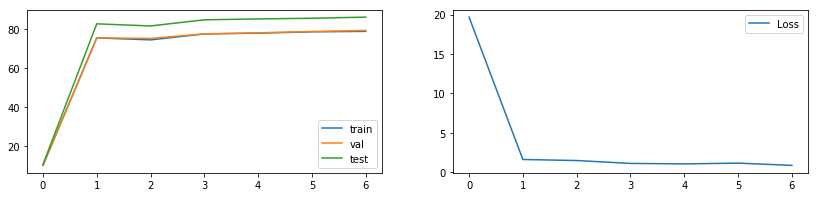

In [190]:
run_nn(one_layer_graph)

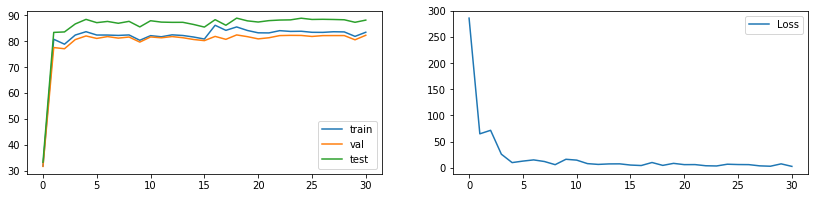

In [184]:
run_nn(two_layers_graph)

---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---